# Beer segmenter

## Project domain and context
The project aims to be a solution based on the filters from a previous project I recently contributed to. The overall project involved the creation of a robotic bar capable of managing the ordering of a certain number of beers, filling up to 4 glasses in parallel, and finally serving them. 

My task was to create a recognition system to detect the level of beer poured and trigger a signal to the system that controlled the dispenser when a glass was filled. (This task could have been solved without using a visual recognition system since the dispensing pressure was constant, and there was a system responsible for keeping it stable, but apparently, the designer of the robotic bar wanted to do things the hard way...)

To do this, I had a camera positioned next to the beer dispenser that allowed me to view the glass from above. Given the position, it was not possible to estimate the volume poured because the view wasn't lateral, so the idea was to segment the foam and interrupt the pouring when the segmented area exceeded a certain threshold.

Fortunately, the liquid pressure allowed for a thick foam from start to finish, avoiding gaps where the color of the beer might show. This task was solved using a YOLO-based segmenter fine-tuned to recognize the shape of the beer.

## Image processing based solution
This notebook presents an image-processing-based solution for the same problem, here are reported the complete workflow to reach a similar solution to the one obtained with AI.

## Preview of the solutions

In [69]:
from IPython.display import display, HTML

html_code = '''
<div style="display: flex; justify-content: space-between; align-items: flex-start;">
    <div style="text-align: center;">
        <h3>AI solution</h3>
        <video width="100%" controls>
            <source src="ai_result.mp4" type="video/mp4">
            Your browser does not support the video tag.
        </video>
    </div>
    <div style="text-align: center;">
        <h3>Image processing solution</h3>
        <video width="100%" controls>
            <source src="result.mp4" type="video/mp4">
            Your browser does not support the video tag.
        </video>
    </div>
</div>
'''

display(HTML(html_code))


## Approach
DA FAre

##

## Goal
We are given a video showing a cup while it's being filled with beer. What we want to achieve is to segment the shape of the beer for every frame in order to estimate the beer-level percentage. Below it's showed a raw video we will use to explain the workflow to achieve the result.

In [70]:
from IPython.display import display, HTML

html_code = '''
<div style="display: block; justify-content: space-between; align-items: flex-start;">
    <h3>Raw video</h3>
    <video width="50%" controls>
        <source src="raw_video.mov" type="video/mp4">
        Your browser does not support the video tag.
    </video>
</div>
'''
display(HTML(html_code))


## Frame preprocessing
Let's consider a frame of the video.

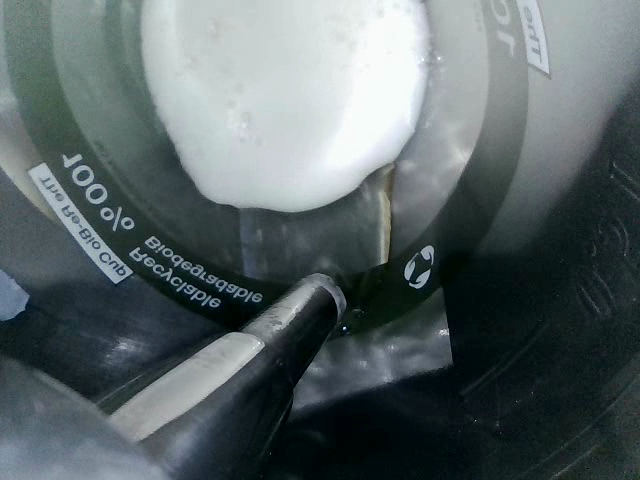

In [71]:
from PIL import Image

frame = Image.open("frames/frame3.png")
display(frame)

I decided to appy the following series of filters:

- **Truncating threshold** to set pixel values above 200 as 200 in order to reduce the intensity of very bright areas like reflections on the foam;
- **Gaussian blur** with a large kernel (13, 13) to remove noise, but more importantly possible bubbles that could make obtain bad contours;
- **Median blur** to attenuate darker points like smaller bubbles particularly in the contours;
- **CLAHE filter**, a filter that enhances local contrast by performing histogram equalization adaptively in small tiles of 4x4 pixels. Boosts contrast in darker areas, making foam structures clearer (filter adopted also for the proprocessing step of the AI solution to ease segmentation);
- **Canny filter** to get a binary image that will be elaborated afeterwads to identify beer contours.

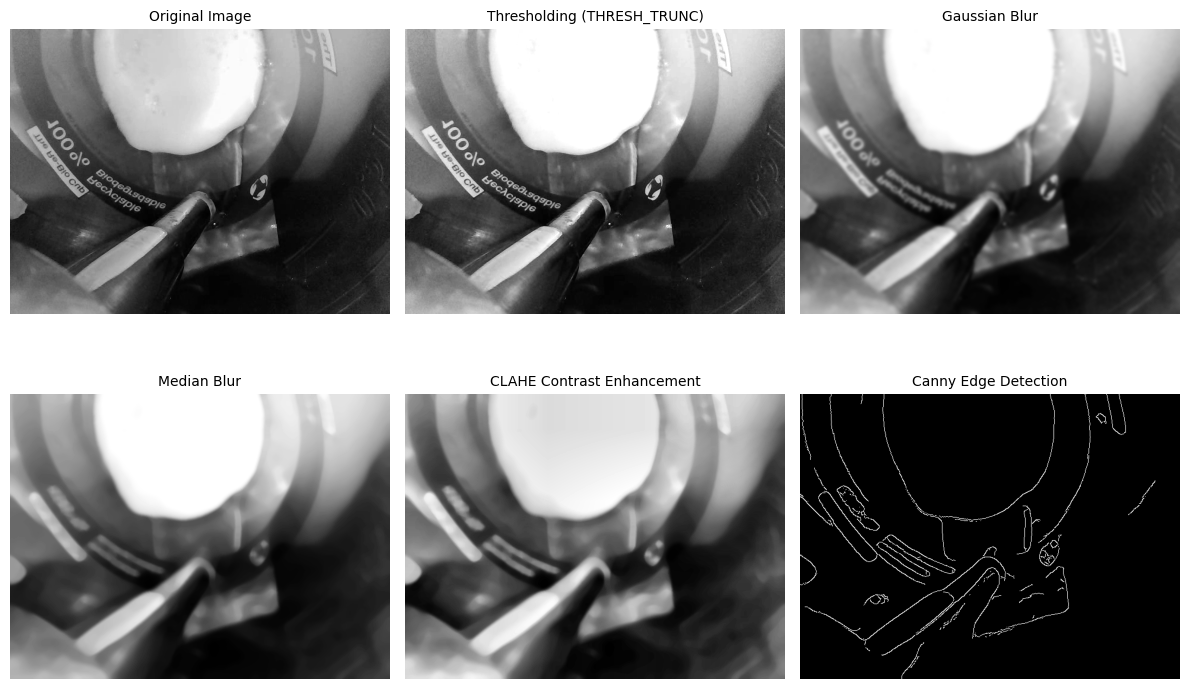

In [72]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Convert PIL image to OpenCV image
img = np.array(frame) # convert to numpy array
frame = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# Step 1: Apply Truncated Thresholding
_, img_thresh = cv2.threshold(img, 200, 255, cv2.THRESH_TRUNC)

# Step 2: Apply Gaussian Blur
img_gauss = cv2.GaussianBlur(img_thresh, (13, 13), 0)

# Step 3: Apply Median Blur
img_median = cv2.medianBlur(img_gauss, 15)

# Step 4: Apply CLAHE (Contrast Enhancement)
clahe = cv2.createCLAHE(clipLimit=1.8, tileGridSize=(4, 4))
img_clahe = clahe.apply(img_median)

# Step 5: Apply Canny Edge Detection
img_canny = cv2.Canny(img_clahe, threshold1=30, threshold2=80)


# SHOWING STEPS - Create a mosaic grid with labels
titles = ["Original Image", "Thresholding (THRESH_TRUNC)", 
          "Gaussian Blur", "Median Blur", 
          "CLAHE Contrast Enhancement", "Canny Edge Detection"]
images = [img, img_thresh, img_gauss, img_median, img_clahe, img_canny]

# Plot the images in a 2x3 grid
plt.figure(figsize=(12, 8))

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i], cmap="gray")
    plt.title(titles[i], fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()


Despite we can already see the foam's contour, the lines we obtained are not suitable to get a good segmentation because they are fragmented. We need to perform a **dilate operation** to connect the small gaps between edges obtained by the Canny filter.

`Dilation` is a morphological operation that expands the white (or bright) regions in an image. It is commonly used in noise removal, enhancing object boundaries, and bridging small gaps in segmented images (as in our case).

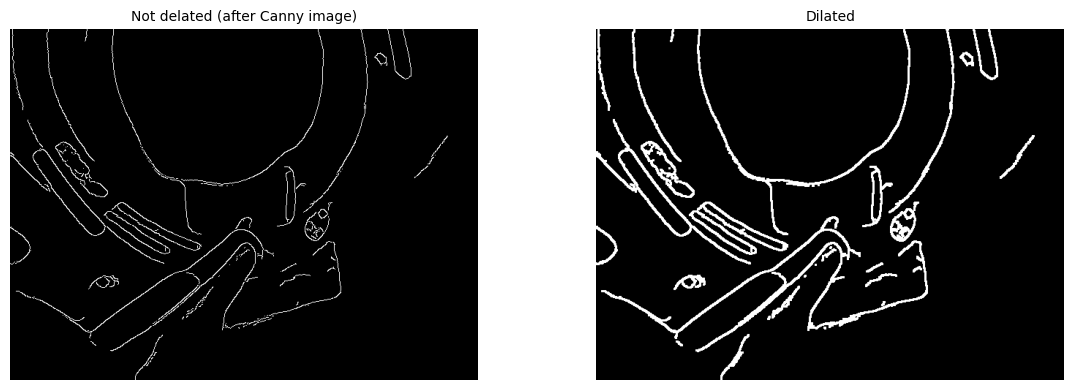

In [73]:

kernel = np.ones((3, 3), np.uint8)
dilated_img = cv2.dilate(img_canny, kernel, iterations=1)

# Create a 1-row, 3-column figure
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 3 columns

# List of images and titles
images = [img_canny, dilated_img]
titles = ["Not delated (after Canny image)", "Dilated"]

# Loop to display images
for i, ax in enumerate(axes):
    ax.imshow(images[i], cmap='gray')
    ax.set_title(titles[i], fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()

As one can notice we have a large number of contours and we need to find a way to select the circular-like shape located in the upper part of the image. I tried to use a Freeman chain code to select contours that resemble a circle or an ellipsis but it typically selected other contours in the image and not the shape of the foam, probably because it is eccesively irregular and not a closed line.

Among the many contours obtained with the Canny filter we need to select just the contour of the foam. Initially, I tried to leverage the ellispsis-like shape of the beer contour. So, I tried also to estimate ellipses from contours, in order to select contours that resembles it but, due to the fact that the shape is not closed the algorithm tended to take archs just archs. Like in the image below.

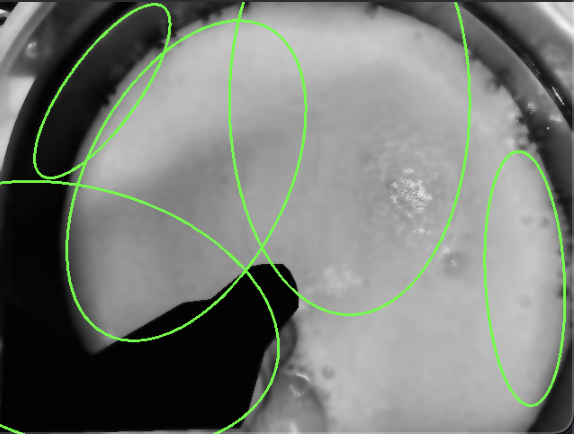

In [74]:
test_image = Image.open('assets/test1.png')
display(test_image)


Thus, I decided to employ a different strategy by leveraging problem's properties. I observed that:

1. If the foam is prepocessed properly its contour will be almost or completely void;
2. The glass is always in the same initial position and the robotic arm always performs the same movement, so that the shape of the foam will always follow the same path and will enlarge in a fairly constant way. The only exception is when the arm straightens the glass and there is a decrease in the area, since it is initially positioned inclined.

The idea is to set a `probable center` that would fall always around the center of the foam and select the nearest contours.

## Finding inner contours

This function takes in input the edges obtained by the Canny filter and the current position of center and traces 360 rays around the point to select the surrounding edges.

In [75]:
def find_inner_contour(edges, center, num_rays=360):
    height, width = edges.shape
    angles = np.linspace(0, 2 * np.pi, num_rays)
    contour_points = []
    
    for angle in angles:
        for r in range(1, min(width, height)):
            x = int(center[0] + r * np.cos(angle))
            y = int(center[1] + r * np.sin(angle))
            
            if 0 <= x < width and 0 <= y < height and edges[y, x] > 0:
                contour_points.append([x, y])
                break
    
    return np.array(contour_points, dtype=np.int32)

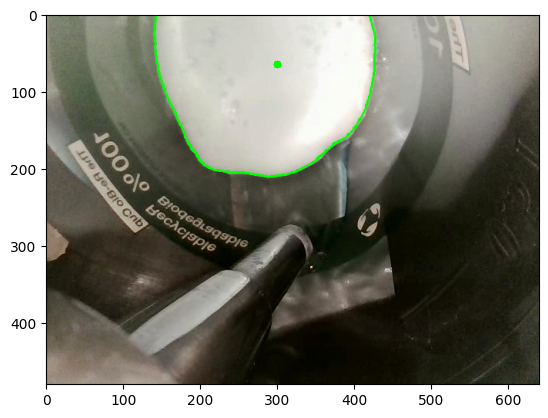

In [78]:
# Find the inner contour of the ellipse
center = (300, 65)
ellipse_contour = find_inner_contour(dilated_img, center=center)

#show
img = frame.copy()
img = cv2.circle(img, center, 5, (0, 255, 0), -1)
img = cv2.drawContours(img, [ellipse_contour], -1, (0, 255, 0), 2)
plt.imshow(img)


## Segmenting larger foam

When the foam becomes bigger this methods doesn't work very well.

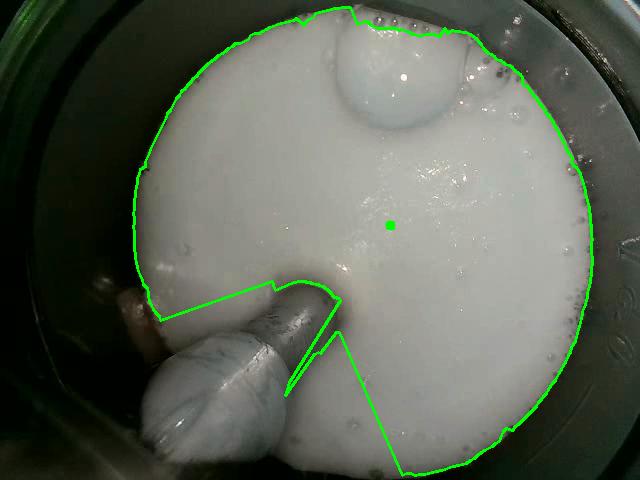

In [92]:
frame = Image.open("frames/frame6.png") # frame with larger foam
center = (390, 225)

def load_and_preprocess_image(frame):
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    _, img = cv2.threshold(img, 200, 255, cv2.THRESH_TRUNC)
    blurred = cv2.GaussianBlur(img, (13, 13), 0)
    blurred = cv2.medianBlur(blurred, 15)
    clahe = cv2.createCLAHE(clipLimit=1.8, tileGridSize=(4, 4))
    blurred = clahe.apply(blurred)
    edges = cv2.Canny(blurred, threshold1=30, threshold2=80)
    return edges

frame = np.array(frame)
edges = load_and_preprocess_image(frame)

dilated = cv2.dilate(edges, kernel, iterations=1)
contours = find_inner_contour(dilated, center)

frame = cv2.circle(frame, center, 5, (0, 255, 0), -2)
frame = cv2.drawContours(frame, [contours], -1, (0, 255, 0), 2)
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
display(Image.fromarray(frame))


!!!!!!!!`Introdurre` e perchè li usi -> quindi spiega che funziona bene quando hai bianco nella schiuma e il resto del bicchiere è scuro.

manca remove_region (spiegare quando hai qualcosa di più grande)

**Segna anche limitations:**
se l'illuminazione è più scarsa, come sul video 3. il prim ometodo per inner contours non funziona bene, mentre kmeans va meglio per la parte finale, altrimenti viene fregato dalle etichette sul bicchiere

Potrebbe essere aggiunta un'analisi di movimento per gestire meglio la segmentazione da un frame all'altro, in modo da essere meno scattoso, controllando cosa è cambiato da uno all'altro.

Dire che quando passi al video fai un frame alla volta, non sono riuscito ad usare l'analisi movimento, che poteva essere utile.

`Test`